### Importing Libraries
***

In [16]:
# import libraries
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [17]:
# import dataset (comes with colab!)
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [18]:
data.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

### EDA
***

In [19]:
# shape of the data matrix
data.shape

(42000, 785)

In [20]:
# extract labels (number IDs) and remove from data
labels = data['label']
data = data.drop(['label'], axis=1)

print(labels.shape)
print(data.shape)

(42000,)
(42000, 784)


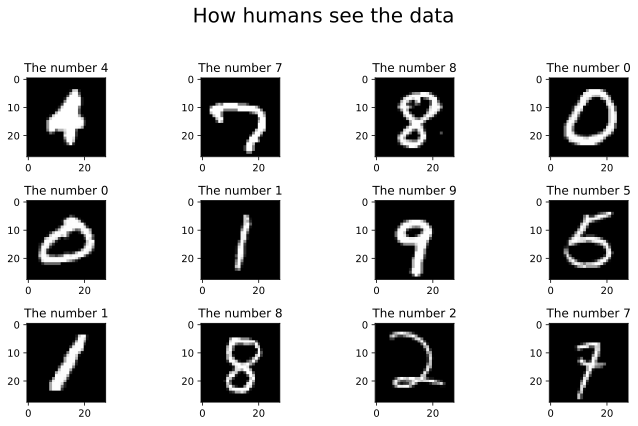

In [21]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(data.iloc[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How humans see the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

In [22]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image
  ax.plot(data.iloc[randimg2show,:],'ko')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How the FFN model sees the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

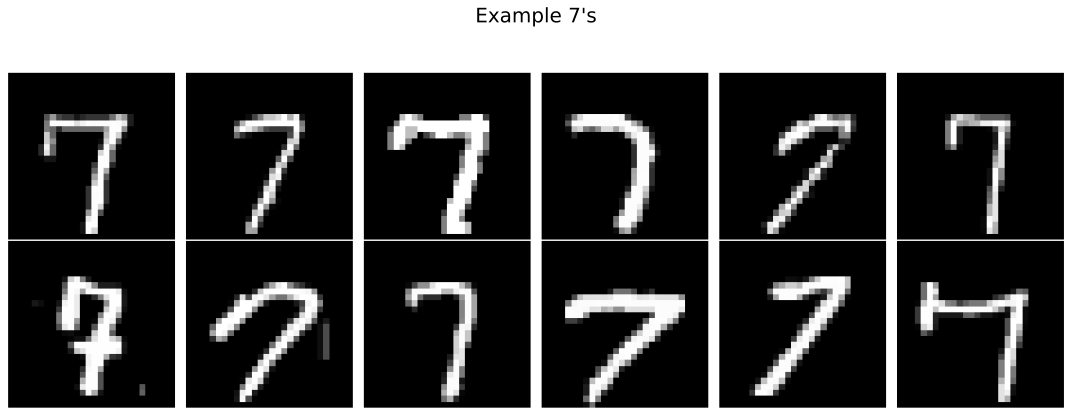

In [23]:
# let's see some example 7s

# find indices of all the 7's in the dataset
the7s = np.where(labels==7)[0]

# draw the first 12
fig,axs = plt.subplots(2,6,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):
  img = np.reshape(data.iloc[the7s[i],:],(28,28))
  ax.imshow(img,cmap='gray')
  ax.axis('off')

plt.suptitle("Example 7's",fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

In [ ]:
# how similar are all the 7's? 

# how many 7's are there?
print(data.iloc[the7s,:].shape)


# let's see how they relate to each other by computing spatial correlations
C = np.corrcoef(data.iloc[the7s,:])

# and visualize
fig,ax = plt.subplots(1,3,figsize=(16,6))
ax[0].plot(C)
ax[0].set_title("Correlation across all 7's")

# extract the unique correlations and show as a scatterplot
uniqueCs = np.triu(C,k=1).flatten()
ax[1].hist(uniqueCs[uniqueCs!=0],bins=100)
ax[1].set_title('All unique correlations')
ax[1].set_xlabel("Correlations of 7's")
ax[1].set_ylabel('Count')

# show all 7's together
aveAll7s = np.reshape( np.mean(data.iloc[the7s,:],axis=0) ,(28,28))
ax[2].imshow(aveAll7s,cmap='gray')
ax[2].set_title("All 7's averaged together")

plt.tight_layout()
plt.show()

(4401, 784)


### Preprocess the data
***

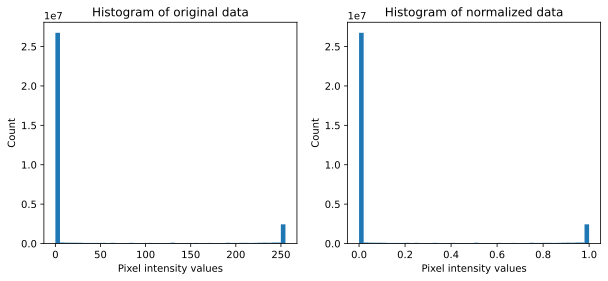

In [27]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.to_numpy().flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.to_numpy().flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

### Create train/test groups using DataLoader
***

In [29]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm.to_numpy()).float()
labelsT = torch.tensor(labels.to_numpy()).long()  # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [30]:
# check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
C                   ndarray          4401x4401: 19368801 elems, type `float64`, 154950408 bytes (147.77222442626953 Mb)
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
aveAll7s            ndarray          28x28: 784 elems, type `float64`, 6272 bytes
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
axs                 ndarray          2x6: 12 elems, type `object`, 96 bytes
batchsize           int              32
data                DataFrame               pixel0  pixel1  pi<...>42000 rows x 784 columns]
dataNorm            DataFrame               pixel0  pixel1  pi<...>42000 rows x 784 columns]
dataT               Tensor           tensor([[0., 0., 0.,  ...<.

### DL model
***

In [31]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [32]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [35]:
trainAcc,testAcc,losses,net = function2trainTheModel()

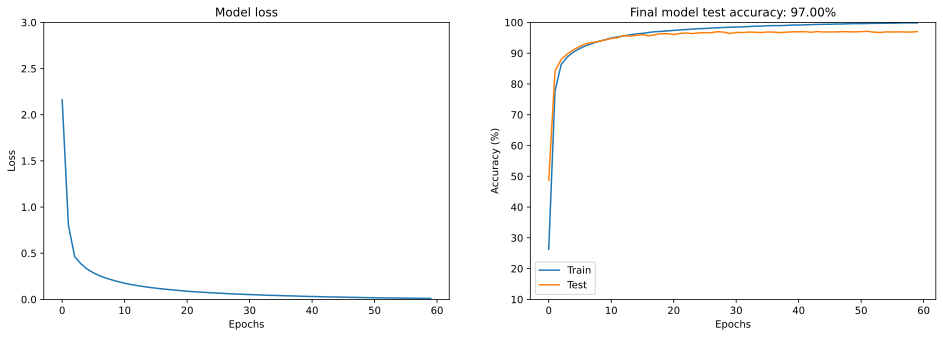

In [36]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Inspect the results
***

In [38]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-1.3346e+01, -3.6162e+01, -2.2320e+01,  ..., -4.0123e+01,
         -3.0974e+01, -3.5246e+01],
        [-2.0230e+01, -2.4263e+01, -6.5801e-05,  ..., -9.8425e+00,
         -1.8866e+01, -1.7411e+01],
        [-2.1928e+01, -2.6623e+01, -2.6408e+01,  ..., -1.6819e+01,
         -1.3073e+01, -3.5166e-05],
        ...,
        [-4.6202e+01, -4.1295e+01, -2.4959e+01,  ...,  0.0000e+00,
         -3.8680e+01, -3.0326e+01],
        [-1.0612e+01, -2.6947e+01, -1.1616e+01,  ..., -2.1485e+01,
         -2.0912e+01, -1.9229e+01],
        [-1.3686e+01, -4.0942e+01, -2.5743e+01,  ..., -4.3978e+01,
         -1.5037e+01, -3.0326e+01]])

[   4   21   44   47   79  126  143  148  152  157  171  208  234  271
  286  313  389  422  434  454  476  563  577  648  878  909  926  942
  951  977 1017 1062 1094 1134 1219 1235 1270 1329 1338 1363 1384 1419
 1421 1445 1454 1497 1504 1532 1552 1553 1598 1602 1631 1633 1714 1774
 1808 1857 1886 1941 1976 1977 2032 2039 2145 2168 2214 2221 2243 2256
 2324 2400 2401 2407 2449 2458 2487 2568 2580 2636 2661 2685 2720 2751
 2834 2858 2891 2925 2934 2935 2954 3016 3040 3049 3050 3070 3082 3096
 3155 3199 3265 3296 3298 3371 3378 3465 3479 3483 3511 3525 3535 3573
 3746 3791 3799 3842 3885 3899 3915 3930 3967 4017 4036 4096 4117 4130]


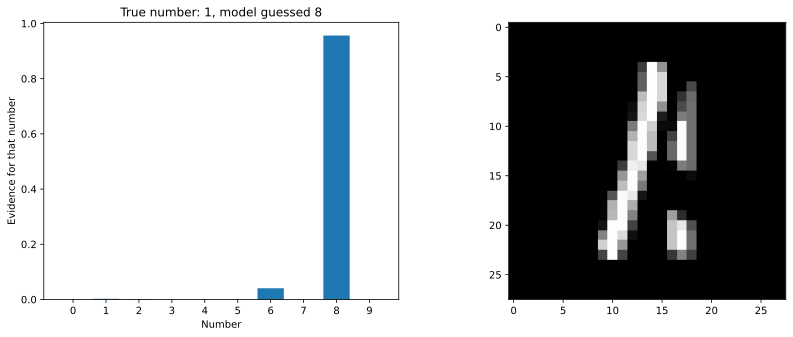

In [41]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 20

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

### Trying different optimizers
***

In [42]:
# create a class for the model
def createTheMNISTNet(optimizerAlgo,learningrate):

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=learningrate)

  return net,lossfun,optimizer

In [43]:
# a function that trains the model

def function2trainTheModel(optimizerAlgo,learningrate):

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(optimizerAlgo,learningrate)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# note: this experiment takes ~30 mins

# variables to loop over
learningRates = np.logspace(np.log10(.0001),np.log10(.1),6)
optimTypes = ['SGD','RMSprop','Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates),len(optimTypes)))


# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
  for idx_l,lr in enumerate(learningRates):
    trainAcc,testAcc,losses,net = function2trainTheModel(opto,lr)
    finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])

In [ ]:
# plot the results! 
plt.plot(learningRates,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()